# Task 3
# Sentiment Analysis

Nixon Andika / 13517059  
Ferdy Santoso / 13517116  
Jan Meyer Saragih / 13517131

## Imports

In [22]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import string
import tensorflow as tf
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import pickle
from pattern.en import spelling

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Constants

In [20]:
sentence_len = 50
unique_word_len = 500
test_size = 0.1
val_size = 0.15
embedding_size = 256
dropout = 0.2
epoch_count = 10

pos_tag_file = 'model/bi_lstm_model.h5'
svm_file = 'model/svm_1.h5'
svm_pos_file = 'mode/svm_pos_1.h5'

## Helper Functions

In [3]:
def save_prep_data():
    pickle.dump(x_train_prep, open('data/x_train_prep.h5', 'wb'))
    pickle.dump(x_val_prep, open('data/x_val_prep.h5', 'wb'))
    pickle.dump(x_test_prep, open('data/x_test_prep.h5', 'wb'))
    pickle.dump(y_train, open('data/y_train.h5', 'wb'))
    pickle.dump(y_val, open('data/y_val.h5', 'wb'))
    pickle.dump(y_test, open('data/y_test.h5', 'wb'))

def load_prep_data():
    x_train_prep = pickle.load(open('data/x_train_prep.h5', 'rb'))
    x_val_prep = pickle.load(open('data/x_val_prep.h5', 'rb'))
    x_test_prep = pickle.load(open('data/x_test_prep.h5', 'rb'))
    y_train = pickle.load(open('data/y_train.h5', 'rb'))
    y_val = pickle.load(open('data/y_val.h5', 'rb'))
    y_test = pickle.load(open('data/y_test.h5', 'rb'))
    return x_train_prep, x_val_prep, x_test_prep, y_train, y_val, y_test

def save_model_pickle(model, filename):
    pickle.dump(model, open(svm_file, 'wb'))

def load_model_pickle(filename):
    model = pickle.load(open(filename, 'rb'))
    return model

## Preprocessing

### Read Data

In [4]:
# Read CSV
df = pd.read_csv('./data/data_3.csv')

In [5]:
# Handle columns
df = df[['review', 'rating']]

In [6]:
# Drop NaNs
df.dropna(inplace = True) 

In [7]:
df['rating'] = df['rating'].replace({ 'Recommended':1, 'Not Recommended': 0})
df

,review,rating
0,My first game on A3 brought me the most horrif...,1
1,This is not a game for people who want fast ac...,1
2,Oh man. Where to even begin with this one. It ...,1
3,This is quite possibly the most emotional shoo...,1
4,"If you have friends, this is a great game to p...",1
...,...,...
79432,This is my life!. MY GAME!,1
79433,Even with all unusual style and gameplay this ...,0
79434,i more of a fan of first person shooter and al...,0
79435,My friends have been going on and on about thi...,0


### Balancing Data

In [8]:
# Oversampling
max_size = df['rating'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('rating'):
    lst.append(group.sample(max_size-len(group), replace=True))
df = pd.concat(lst)

In [9]:
# Reset index, shuffle
df = df.sample(frac=1).reset_index(drop=True)

### Check Data Balance

<AxesSubplot:>

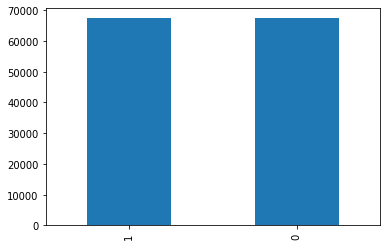

In [10]:
df['rating'].value_counts().plot.bar()

### Train Test Validation Split

#### Get Train Data

In [11]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.1, random_state=3)
for train_idx, test_idx in sss.split(df['review'], df['rating']):
    x_train, x_test = df['review'][train_idx], df['review'][test_idx]
    y_train, y_test = df['rating'][train_idx], df['rating'][test_idx]
    
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Get Test Data

In [12]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.15, random_state=3)
for train_idx, val_idx in sss.split(x_train, y_train):
    idx_train = train_idx
    idx_val = val_idx

y_val = y_train[idx_val]
x_val = x_train[idx_val]
x_train_train = x_train[idx_train]
y_train_train = y_train[idx_train]
x_train = x_train_train
y_train = y_train_train

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

x_train

0             Gandhi declared war on the U.S and won. 10/10
1         The way that this game has been warped; the wa...
2         In this game you will have to play over 100 ga...
3         Do you like games? Get Garry's Mod Everything ...
4         Great game, but this is a step in the wrong di...
                                ...                        
103094                  I'm not paying 50 cents for a sword
103095    I love the fact i wait two years for horrible ...
103096    ING  GAME WITH UNBALANCED  AND  RUSSIANS WHO C...
103097    Hi I'm a big fan of Arma's. I have been, since...
103098          This game is sheite because of paid Maude's
Name: review, Length: 103099, dtype: object

## NLP Preprocessing

### Tokenization and Removing Unnecessary Information

In [13]:
# Eksekusi preprocess untuk satu row data
def execute_preprocess(value):
    # Mendapatkan token seperti kata, tanda baca dari kalimat
    tokenList = word_tokenize(value)
    tokenList = [w.lower() for w in tokenList]

    # Menghilangkan stopwords dalam bahasa Inggris untuk mengurangi jumlah token yang diproses
    stop_words = set(stopwords.words('english'))
    tokenList = [word for word in tokenList if not word in stop_words]
    
    # Menggabungkan semua token menjadi 1 kalimat panjang dengan setiap token dipisahkan oleh spasi
    result = ""
    for token in tokenList:
        if token != "":
            result += token + ' '
    result = result[:-1]
    
    # Remove multiple space and tokens
    result = re.sub(r'[?=.*\!-_,\.]','',result)
    result = re.sub(' +', ' ', result)
    
    return result

# Preprocess setiap baris untuk setiap row dalam data
def preprocess_data(raw_data):
    tokens = []
    for raw in raw_data:
        tokenList = execute_preprocess(raw)
        tokens.append(tokenList)
    return tokens

In [15]:
x_train_prep = preprocess_data(x_train)
x_val_prep = preprocess_data(x_val)
x_test_prep = preprocess_data(x_test)

x_train_prep

['gandhi declared war us ',
 'way game warped way modding community community kept game alive years forced turn ruined game longer exist innocent modding community community built solely mutual respect love game hobby good faith recommend game anyone current state nothing positive supersede massive negative implemented valve ',
 'game play games hundreds hours get ranked games see bad put matches feeders nt speak language flame relentlesly lose noobs call mid feed wo nt map vision prepared spend hour game probably lose would recommend ',
 'like games get garry s mod everything like games pretty much garry s mod nuff said ',
 'great game step wrong direction modding community valve forgot evil ',
 'fun game beautiful graphics good action however s freetopay game never near enough currency buy weapons warframes ',
 'horrible buy game find bug game keeps loading screen forever one knows fix bs',
 'bought game day release pc game ran perfectly fine fact ran even better expected nt issues s

### Save and Load Prep File

In [16]:
save_prep_data()
x_train_prep, x_val_prep, x_test_prep, y_train, y_val, y_test = load_prep_data()
y_train

0         1
1         0
2         1
3         1
4         0
         ..
103094    0
103095    0
103096    0
103097    0
103098    0
Name: rating, Length: 103099, dtype: int64

### POS Tagging

In [56]:
str_test = 'a i u e o'
print(str_test[1:])

 i u e o


In [63]:
from posTagger import posTagger

def split_string_to_list(string_list):
    splitted_strings = []
    for string_comp in string_list:
        splitted_strings.append(string_comp.split())
    return splitted_strings

def append_pos_tag(string_list, pos_tag_list):
    append_strings = []
    for i in range(len(string_list)):
        string_total = ""
        for j in range(len(string_list[i])):
            string_total += ' '
            string_total += string_list[i][j] + pos_tag_list[i][j]
        append_strings.append(string_total[1:])
    return append_strings

In [54]:
x_train_prep_split =split_string_to_list(x_train_prep)

posTag = posTagger()
x_train_pos = posTag.pos_tag(x_train_prep_split)

x_train_pos

[['NOUN', 'VERB', 'NOUN', 'PRON'],
 ['NOUN',
  'NOUN',
  'VERB',
  'NOUN',
  'NOUN',
  'NOUN',
  'NOUN',
  'VERB',
  'NOUN',
  'ADJ',
  'NOUN',
  'VERB',
  'NOUN',
  'VERB',
  'NOUN',
  'ADV',
  'VERB',
  'ADJ',
  'ADJ',
  'NOUN',
  'NOUN',
  'VERB',
  'ADV',
  'ADJ',
  'NOUN',
  'NOUN',
  'NOUN',
  'NOUN',
  'ADJ',
  'NOUN',
  'VERB',
  'NOUN',
  'NOUN',
  'ADJ',
  'NOUN',
  'NOUN',
  'ADJ',
  'NOUN',
  'ADJ',
  'ADJ',
  'VERB'],
 ['NOUN',
  'NOUN',
  'NOUN',
  'NOUN',
  'NOUN',
  'VERB',
  'VERB',
  'NOUN',
  'VERB',
  'ADJ',
  'VERB',
  'NOUN',
  'NOUN',
  'NOUN',
  'VERB',
  'NOUN',
  'NOUN',
  'NOUN',
  'VERB',
  'NOUN',
  'NOUN',
  'ADJ',
  'NOUN',
  'VERB',
  'X',
  'NOUN',
  'NOUN',
  'VERB',
  'VERB',
  'NOUN',
  'NOUN',
  'ADV',
  'VERB',
  'VERB',
  'VERB'],
 ['ADP',
  'NOUN',
  'VERB',
  'NOUN',
  'NOUN',
  'VERB',
  'NOUN',
  'ADP',
  'NOUN',
  'ADV',
  'ADJ',
  'NOUN',
  'NOUN',
  'NOUN'],
 ['ADJ', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB'],
 ['NOUN',
 

In [74]:
print(len(x_train_prep_split[3]))
print(len(x_train_pos[3]))
x_train_tagged = append_pos_tag(x_train_prep_split, x_train_pos)
x_train_tagged

16
14


IndexError: list index out of range

In [41]:
print(len(x_train_pos[1]))
print(x_train_prep[0])

256
gandhi declared war us 


## Feature Extraction (TF-IDF)

### Fitting

In [ ]:
tfidf = TfidfVectorizer(binary=True, use_idf = True, max_features=256)
tfidf = tfidf.fit(x_train_prep)
tfidf

### Extracting

In [ ]:
x_train_tfidf = pd.DataFrame(tfidf.transform(x_train_prep).toarray(), columns=[tfidf.get_feature_names()])
x_val_tfidf = pd.DataFrame(tfidf.transform(x_val_prep).toarray(), columns=[tfidf.get_feature_names()])
x_test_tfidf = pd.DataFrame(tfidf.transform(x_test_prep).toarray(), columns=[tfidf.get_feature_names()])

x_train_tfidf

## Classification 1: Support Vector Machine (SVM)

### Training

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train_tfidf[:50000], y_train[:50000])

### Testing

In [ ]:
y_test_predict = clf.predict(x_test_tfidf)
y_test_predict

In [ ]:
accuracy = accuracy_score(y_test, y_test_predict)
accuracy

### Save Model

In [ ]:
svm_file = 'model/svm_2.txt'
pickle.dump(clf, open(svm_file, 'wb'))

## Classification 2: Deep Neural Network (DNN)

### Word To Vec

In [ ]:
tokenizer = Tokenizer(num_words = unique_word_len, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token='<<OOV>>')
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train_prep)
x_val = tokenizer.texts_to_sequences(x_val_prep)
x_test = tokenizer.texts_to_sequences(x_test_prep)

x_train

### Padding

In [ ]:
x_train_padded = pad_sequences(x_train, maxlen = sentence_len, padding="pre", truncating="post")
x_val_padded = pad_sequences(x_val, maxlen = sentence_len, padding="pre", truncating="post")
x_test_padded = pad_sequences(x_test, maxlen = sentence_len, padding="pre", truncating="post")

y_train

## Model Building

### Configs

In [ ]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 2)
callback = [early_stopping]

### Building Model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = unique_word_len, output_dim = embedding_size, input_length = sentence_len))
model.add(LSTM(128, dropout = dropout, recurrent_dropout = dropout))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model.summary()

## Training

In [ ]:
print(x_train_padded.shape, x_val_padded.shape, x_test_padded.shape)

### Training

In [ ]:
history = model.fit(x_train_padded, y_train, validation_data=(x_val_padded, y_val), \
                    epochs = epoch_count, batch_size = 64)

In [ ]:
y_pred=(model.predict(x_test_padded)).astype("int32")
y_pred

In [ ]:
print(len(history.history['loss']))
plt.plot(range(1, epoch_count + 1), history.history['accuracy'], 'r--')
plt.plot(range(1, epoch_count + 1), history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
filename = 'model/model1'
pickle.dump(model, open(filename, 'wb'))